# PAF Calculations with the Interactive Sim 

The integration approach to PAF calculations is attempted in PAF calculations. This worked for SBP to HF only as that is a categorical risk. For the BMI continuous risk, the integration did not work as expected. Therefore, we are trying a new approach via the interactive sim. 

The PAFs I need are: 
- BMI to HF 
- BMI to IHD 
- BMI to Stroke

In [1]:
from vivarium import InteractiveContext, Artifact

from datetime import datetime, timedelta
from pathlib import Path
import itertools
import matplotlib.pyplot as plt
import ipywidgets
import pandas as pd, numpy as np
pd.set_option('display.max_rows', 60)
import seaborn as sns

import numpy as np
import researchpy as rp
import statsmodels.api as sm
import statsmodels.formula.api as smf
from matplotlib.backends.backend_pdf import PdfPages
import scipy.stats

In [2]:
path = Path('/ihme/homes/lutzes/vivarium_nih_us_cvd/src/vivarium_nih_us_cvd/model_specifications/nih_us_cvd.yaml')

In [37]:
sim = InteractiveContext(Path(path), setup=False)
sim.configuration.update({
                          'population':
                              {'population_size': 10_000,
                              },
                          'time':
                              {'start':
                                  {'year': 2021
                                  }
                              }
                          }
                        )
sim.setup()

2023-02-10 07:19:35.174 | DEBUG    | vivarium.framework.values:register_value_modifier:392 - Registering metrics.1.population_manager.metrics as modifier to metrics
2023-02-10 07:19:35.272 | DEBUG    | vivarium.framework.artifact.manager:_load_artifact:66 - Running simulation from artifact located at /ihme/costeffectiveness/artifacts/vivarium_nih_us_cvd/alabama.hdf.
2023-02-10 07:19:35.274 | DEBUG    | vivarium.framework.artifact.manager:_load_artifact:67 - Artifact base filter terms are ['draw == 0'].
2023-02-10 07:19:35.278 | DEBUG    | vivarium.framework.artifact.manager:_load_artifact:68 - Artifact additional filter terms are None.
2023-02-10 07:19:35.630 | DEBUG    | vivarium.framework.values:_register_value_producer:338 - Registering value pipeline cause_specific_mortality_rate
2023-02-10 07:19:35.631 | DEBUG    | vivarium.framework.values:_register_value_producer:338 - Registering value pipeline mortality_rate
2023-02-10 07:19:35.984 | DEBUG    | vivarium.framework.values:_regis

In [4]:
pop0 = sim.get_population()
pop0.head()

,tracked,alive,sex,age,exit_time,location,entrance_time,cause_of_death,years_of_life_lost,years_lived_with_disability,...,ldlc_multiplier,polypill,sbp_medication,outreach,sbp_medication_adherence,ldlc_medication,ldlc_medication_adherence,sbp_multiplier,scheduled_date,visit_type
0,True,alive,Female,47.388882,NaT,Alabama,2020-12-04,not_dead,0.0,0.0,...,1.000,cat2,no_treatment,cat2,cat3,no_treatment,cat3,1.0,NaT,none
1,True,alive,Male,41.564194,NaT,Alabama,2020-12-04,not_dead,0.0,0.0,...,1.000,cat2,no_treatment,cat2,cat3,no_treatment,cat3,1.0,NaT,none
2,True,alive,Female,53.155826,NaT,Alabama,2020-12-04,not_dead,0.0,0.0,...,1.362,cat2,one_drug_half_dose_efficacy,cat2,cat1,medium_intensity,cat3,1.0,NaT,none
3,True,alive,Male,30.457692,NaT,Alabama,2020-12-04,not_dead,0.0,0.0,...,1.000,cat2,no_treatment,cat2,cat3,no_treatment,cat1,1.0,NaT,none
4,True,alive,Female,19.554806,NaT,Alabama,2020-12-04,not_dead,0.0,0.0,...,1.000,cat2,no_treatment,cat2,cat3,no_treatment,cat1,1.0,NaT,none


In [5]:
pop1 = pop0[['sex','alive','age']]

In [64]:
#pop0.columns

In [66]:
#sim.list_values()

In [30]:
data1 = pd.concat([pop1,
                   sim.get_value('high_body_mass_index_in_adults.propensity')(pop0.index).rename('bmi_propensity'),
                   sim.get_value('high_body_mass_index_in_adults.exposure')(pop0.index).rename('bmi_exposure'),
                   sim.get_value('high_ldl_cholesterol.propensity')(pop0.index).rename('ldl_propensity'),
                   sim.get_value('high_ldl_cholesterol.exposure')(pop0.index).rename('ldl_exposure'),
                   sim.get_value('high_systolic_blood_pressure.propensity')(pop0.index).rename('sbp_propensity'),
                   sim.get_value('high_systolic_blood_pressure.exposure')(pop0.index).rename('sbp_exposure'),
                   sim.get_value('high_fasting_plasma_glucose.propensity')(pop0.index).rename('fpg_propensity'),
                   sim.get_value('high_fasting_plasma_glucose.exposure')(pop0.index).rename('fpg_exposure'),
                   sim.get_value('acute_myocardial_infarction.incidence_rate')(pop0.index).rename('mi_incidence'),
                   sim.get_value('acute_myocardial_infarction.incidence_rate.paf')(pop0.index).rename('mi_incidence_paf'),
                   sim.get_value('acute_ischemic_stroke.incidence_rate')(pop0.index).rename('stroke_incidence'),
                   sim.get_value('acute_ischemic_stroke.incidence_rate.paf')(pop0.index).rename('stroke_incidence_paf'),
                  ], axis=1)
data1.head()

,sex,alive,age,bmi_propensity,bmi_exposure,ldl_propensity,ldl_exposure,sbp_propensity,sbp_exposure,fpg_propensity,fpg_exposure,mi_incidence,mi_incidence_paf,stroke_incidence,stroke_incidence_paf
0,Female,alive,47.388882,0.208828,23.564850,0.362468,2.672922,0.650952,126.711324,0.839684,5.987195,0.000010,0.967287,0.000008,0.959927
1,Male,alive,41.564194,0.358604,25.661107,0.695510,3.377397,0.625507,135.497307,0.385293,5.480734,0.000028,0.983091,0.000008,0.969345
2,Female,alive,53.155826,0.531571,34.110372,0.155857,1.864838,0.165289,112.215005,0.891604,7.501187,0.000020,0.941682,0.000019,0.947248
3,Male,alive,30.457692,0.388049,26.473747,0.821628,4.959918,0.162353,114.705760,0.584118,5.518632,0.000012,0.990950,0.000001,0.981074
4,Female,alive,19.554806,0.672873,5.000000,0.658736,0.000000,0.479221,50.000000,0.029360,1.000000,0.000008,0.000000,0.000006,0.000000


In [31]:
data1 = data1.loc[(data1.age > 25) & (data1.alive == 'alive')]

In [32]:
age_group = pd.cut(data1.age, bins=[25,30,35,40,45,50,55,60,65,70,75,80,85,90,125],labels=['25_to_30','30_to_35','35_to_40','40_to_45','45_to_50','50_to_55','55_to_60','60_to_65','65_to_70','70_to_75','75_to_80','80_to_85','85_to_90','90_to_125'])
data1.insert(13, 'age_group', age_group)

In [33]:
data1.age_group.unique()

['45_to_50', '40_to_45', '50_to_55', '30_to_35', '35_to_40', ..., '85_to_90', '25_to_30', '70_to_75', '90_to_125', '80_to_85']
Length: 14
Categories (14, object): ['25_to_30' < '30_to_35' < '35_to_40' < '40_to_45' ... '75_to_80' < '80_to_85' < '85_to_90' < '90_to_125']

In [34]:
sex_list = (['Female','Male'])

In [39]:
%%capture --no-display
data1_new = pd.DataFrame()
for sex in [i for i in list(sex_list)]:
    for age in [j for j in list(data1.age_group.unique())]: 
        data_current = data1.loc[(data1.sex == sex) & (data1.age_group == age)]
        data_current.loc[:,'bmi_rank'] = data_current.bmi_exposure.rank()
        data_current.loc[:,'ldl_rank'] = data_current.ldl_exposure.rank()
        data_current.loc[:,'sbp_rank'] = data_current.sbp_exposure.rank()
        data_current.loc[:,'fpg_rank'] = data_current.fpg_exposure.rank()
        data1_new = data1_new.append(data_current)
data1_new

,sex,alive,age,bmi_propensity,bmi_exposure,ldl_propensity,ldl_exposure,sbp_propensity,sbp_exposure,fpg_propensity,fpg_exposure,mi_incidence,mi_incidence_paf,age_group,stroke_incidence,stroke_incidence_paf,bmi_rank,ldl_rank,sbp_rank,fpg_rank
0,Female,alive,47.388882,0.208828,23.564850,0.362468,2.672922,0.650952,126.711324,0.839684,5.987195,0.000010,0.967287,45_to_50,0.000008,0.959927,82.0,142.0,248.0,306.0
18,Female,alive,47.593991,0.989864,49.302438,0.346926,2.597841,0.074565,104.827776,0.553424,4.605126,0.000058,0.967287,45_to_50,0.000093,0.959927,360.0,129.0,20.0,194.0
71,Female,alive,46.463245,0.161256,21.044691,0.328825,2.642607,0.083860,103.161416,0.764854,6.101083,0.000005,0.967287,45_to_50,0.000004,0.959927,42.0,137.0,15.0,311.0
76,Female,alive,49.802613,0.139220,22.158965,0.075035,1.729700,0.174775,110.805907,0.632020,4.864043,0.000003,0.967287,45_to_50,0.000003,0.959927,59.0,21.0,52.0,222.0
84,Female,alive,49.964748,0.463160,32.736415,0.389316,2.656644,0.601588,123.820624,0.294664,3.946931,0.000021,0.967287,45_to_50,0.000022,0.959927,219.0,139.0,211.0,119.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8989,Male,alive,81.848497,0.640466,29.184111,0.191945,2.091435,0.431516,134.081197,0.971753,11.459140,0.001172,0.721583,80_to_85,0.000368,0.587276,51.0,18.0,44.0,73.0
9608,Male,alive,84.973974,0.424359,25.336148,0.219816,1.853907,0.326979,127.049571,0.963026,10.690062,0.000816,0.721583,80_to_85,0.000291,0.587276,25.0,9.0,23.0,71.0
9772,Male,alive,82.620335,0.922729,33.001578,0.935793,4.061447,0.355575,127.738665,0.667106,7.393472,0.001938,0.721583,80_to_85,0.000509,0.587276,62.0,71.0,27.0,56.0
9982,Male,alive,83.277997,0.307639,23.991826,0.149850,1.869206,0.637676,135.093925,0.934441,9.483259,0.000916,0.721583,80_to_85,0.000324,0.587276,20.0,12.0,46.0,69.0


(array([1046.,  964.,  875.,  857.,  803.,  762.,  686.,  664.,  558.,
         233.]),
 array([  1. ,  38.9,  76.8, 114.7, 152.6, 190.5, 228.4, 266.3, 304.2,
        342.1, 380. ]),
 <BarContainer object of 10 artists>)

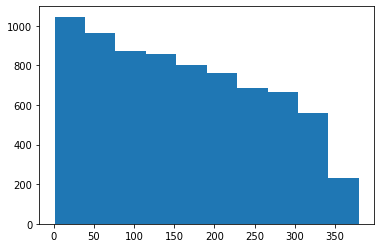

In [41]:
plt.hist(data1_new.fpg_rank)

Given that the ranks max out around 350 and drop off for higher numbers (less age/sex groups have more people in them) I am assuming the above loop worked as intended. 

In [42]:
correlation = pd.read_csv('/ihme/homes/lutzes/correlation.csv')
correlation = correlation.drop('Unnamed: 0',axis=1)
old_age = {'age_start': 90, 'age_end': 125, 'sbp_ldl': 0.124353,'sbp_ldl_pval':1.754506e-104,'sbp_bmi':0.005323,'sbp_bmi_pval':9.405201e-01,'ldl_bmi':0.111832,'ldl_bmi_pval':3.384224e-86,'sbp_fpg':0.338096,'sbp_fpg_pval':0,'ldl_fpg':0,'ldl_fpg_pval':'NaN','bmi_fpg':0.294275,'bmi_fpg_pval':0}
correlation = correlation.append(old_age, ignore_index = True)
#correlation

/tmp/ipykernel_2362068/3274002491.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  correlation = correlation.append(old_age, ignore_index = True)


In [44]:
%%capture --no-display
data_all = pd.DataFrame()
#N = 1000 #can change to be the total population size needed 
for i in range(0,len(correlation)):
    age_start = correlation.iloc[i][0]
    age_end = correlation.iloc[i][1]
    sbp_ldl = correlation.iloc[i][2]
    sbp_bmi = correlation.iloc[i][4]
    bmi_ldl = correlation.iloc[i][6]
    sbp_fpg = correlation.iloc[i][8]
    ldl_fpg = correlation.iloc[i][10]
    bmi_fpg = correlation.iloc[i][12]
    N = len(data1.loc[(data1.age > age_start) & (data1.age < age_end)])
    probit_propensity = np.random.multivariate_normal([0,0,0,0], [[1, sbp_ldl, sbp_bmi, sbp_fpg],
                                                         [sbp_ldl, 1, bmi_ldl, ldl_fpg],
                                                         [sbp_bmi, bmi_ldl, 1, bmi_fpg],
                                                             [sbp_fpg, ldl_fpg, bmi_fpg, 1]], size=N)
    propensity = scipy.stats.norm().cdf(probit_propensity)
    data = pd.DataFrame(data = propensity, 
                       columns = ['SBP','LDL','BMI','FPG'])
    data['age_start'] = age_start
    data['age_end'] = age_end
    data_all = data_all.append(data)
data_all = data_all.reset_index()

In [45]:
#Checking that this worked as expected and it does! 
len(data_all), len(data1_new)

(7448, 7448)

In [46]:
data_new = data1_new[['age','sex']]
data_new = data_new.sort_values(by=['age']).reset_index()
data_new = data_new.drop('index',axis=1)
#data_new.head()

In [47]:
data_new = pd.concat([data_new, data_all], axis=1)

In [48]:
data_new['age_group'] = [f'{int(i)}_to_{int(j)}' for (i,j) in zip(data_new.age_start,data_new.age_end)]
data_new.head()

,age,sex,index,SBP,LDL,BMI,FPG,age_start,age_end,age_group
0,25.006635,Female,0,0.257518,0.238146,0.401916,0.665645,25,30,25_to_30
1,25.014514,Male,1,0.029109,0.140510,0.111094,0.237338,25,30,25_to_30
2,25.018104,Male,2,0.694108,0.730077,0.507441,0.341806,25,30,25_to_30
3,25.021147,Male,3,0.923840,0.837401,0.490721,0.673831,25,30,25_to_30
4,25.038105,Male,4,0.581824,0.533019,0.085199,0.364232,25,30,25_to_30


In [49]:
#Just wanted to check that matching in this way worked as I expected and it seems that it did! 
count=0
for i in range(7448):
    if [(data_new.age.iloc[i] > data_new.age_start.iloc[i]) & (data_new.age.iloc[i] > data_new.age_end.iloc[i])]:
        count = count + 1
print(count)

7448


In [50]:
%%capture --no-display
data_final = pd.DataFrame()
for sex in [i for i in list(sex_list)]:
    for age in [j for j in list(data_new.age_group.unique())]: 
        data_current = data_new.loc[(data_new.sex == sex) & (data_new.age_group == age)]
        data_current['bmi_rank'] = data_current.BMI.rank()
        data_current['ldl_rank'] = data_current.LDL.rank()
        data_current['sbp_rank'] = data_current.SBP.rank()
        data_current['fpg_rank'] = data_current.FPG.rank()
        data_final = data_final.append(data_current)
data_final

,age,sex,index,SBP,LDL,BMI,FPG,age_start,age_end,age_group,bmi_rank,ldl_rank,sbp_rank,fpg_rank
0,25.006635,Female,0,0.257518,0.238146,0.401916,0.665645,25,30,25_to_30,145.0,94.0,102.0,268.0
6,25.067368,Female,6,0.146438,0.178953,0.290511,0.173580,25,30,25_to_30,108.0,70.0,70.0,68.0
7,25.076838,Female,7,0.229340,0.038013,0.598475,0.191093,25,30,25_to_30,222.0,18.0,92.0,73.0
8,25.083359,Female,8,0.455931,0.044679,0.195943,0.090618,25,30,25_to_30,74.0,23.0,167.0,29.0
11,25.100092,Female,11,0.898786,0.510473,0.989587,0.930771,25,30,25_to_30,367.0,193.0,329.0,352.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7436,97.466628,Male,52,0.173911,0.424553,0.892132,0.434538,90,125,90_to_125,18.0,12.0,5.0,13.0
7437,97.789606,Male,53,0.133690,0.344969,0.737086,0.102204,90,125,90_to_125,15.0,9.0,4.0,5.0
7441,100.593125,Male,57,0.498584,0.618703,0.767671,0.748556,90,125,90_to_125,17.0,13.0,11.0,15.0
7444,104.731512,Male,60,0.659223,0.199779,0.465519,0.336443,90,125,90_to_125,14.0,5.0,13.0,10.0


In [51]:
%%capture --no-display
data_final_all = pd.DataFrame()
for sex in [i for i in list(sex_list)]:
    for age in [j for j in list(data_new.age_group.unique())]: 
        data_current_1 = data_final.loc[(data_final.sex == sex) & (data_final.age_group == age)]
        data_current_2 = data1_new.loc[(data1_new.sex == sex) & (data1_new.age_group == age)]
        data_current_1 = data_current_1.sort_values(by=['bmi_rank']).reset_index()
        data_current_2 = data_current_2.sort_values(by=['bmi_rank']).reset_index() 
        data_current_all = pd.concat([data_current_1, data_current_2['bmi_exposure']], axis=1)
        data_final_all = data_final_all.append(data_current_all)

In [52]:
data_final_all = data_final_all.drop(['level_0'],axis=1)
#data_final_all

In [53]:
%%capture --no-display
data_final_all_2 = pd.DataFrame()
for sex in [i for i in list(sex_list)]:
    for age in [j for j in list(data_new.age_group.unique())]: 
        data_current_1 = data_final_all.loc[(data_final_all.sex == sex) & (data_final_all.age_group == age)]
        data_current_2 = data1_new.loc[(data1_new.sex == sex) & (data1_new.age_group == age)]
        data_current_1 = data_current_1.sort_values(by=['ldl_rank']).reset_index()
        data_current_2 = data_current_2.sort_values(by=['ldl_rank']).reset_index() 
        data_current_all = pd.concat([data_current_1, data_current_2['ldl_exposure']], axis=1)
        data_final_all_2 = data_final_all_2.append(data_current_all)

In [54]:
data_final_all_2 = data_final_all_2.drop(['level_0'],axis=1)
#data_final_all_2

In [59]:
%%capture --no-display
data_final_all_3 = pd.DataFrame()
for sex in [i for i in list(sex_list)]:
    for age in [j for j in list(data_new.age_group.unique())]: 
        data_current_1 = data_final_all_2.loc[(data_final_all_2.sex == sex) & (data_final_all_2.age_group == age)]
        data_current_2 = data1_new.loc[(data1_new.sex == sex) & (data1_new.age_group == age)]
        data_current_1 = data_current_1.sort_values(by=['sbp_rank']).reset_index()
        data_current_2 = data_current_2.sort_values(by=['sbp_rank']).reset_index() 
        data_current_all = pd.concat([data_current_1, data_current_2['sbp_exposure']], axis=1)
        data_final_all_3 = data_final_all_3.append(data_current_all)

In [60]:
data_final_all_3 = data_final_all_3.drop(['level_0'],axis=1)
#data_final_all_3

In [83]:
%%capture --no-display
data_final_all_4 = pd.DataFrame()
for sex in [i for i in list(sex_list)]:
    for age in [j for j in list(data_new.age_group.unique())]: 
        data_current_1 = data_final_all_3.loc[(data_final_all_3.sex == sex) & (data_final_all_3.age_group == age)]
        data_current_2 = data1_new.loc[(data1_new.sex == sex) & (data1_new.age_group == age)]
        data_current_1 = data_current_1.sort_values(by=['fpg_rank']).reset_index()
        data_current_2 = data_current_2.sort_values(by=['fpg_rank']).reset_index() 
        data_current_all = pd.concat([data_current_1, data_current_2['fpg_exposure']], axis=1)
        data_final_all_4 = data_final_all_4.append(data_current_all)

In [84]:
data_final_all_4 = data_final_all_4.drop(['level_0'],axis=1)
data_final_all_4

,age,sex,index,SBP,LDL,BMI,FPG,age_start,age_end,age_group,bmi_rank,ldl_rank,sbp_rank,fpg_rank,bmi_exposure,ldl_exposure,sbp_exposure,fpg_exposure
0,26.954833,Female,288,0.052707,0.100496,0.167871,0.006825,25,30,25_to_30,67.0,46.0,23.0,1.0,22.558860,2.034673,99.042498,3.775154
1,26.139120,Female,159,0.035351,0.161465,0.082288,0.008169,25,30,25_to_30,29.0,63.0,14.0,2.0,18.431675,2.204112,97.708191,4.408998
2,26.283914,Female,182,0.104709,0.967980,0.309098,0.016048,25,30,25_to_30,113.0,363.0,47.0,3.0,25.353911,4.605598,102.151440,4.479700
3,28.101016,Female,465,0.006075,0.685091,0.442381,0.017722,25,30,25_to_30,166.0,248.0,2.0,4.0,28.592596,3.204607,82.531206,4.485260
4,29.294331,Female,645,0.316964,0.584806,0.040068,0.018268,25,30,25_to_30,17.0,214.0,113.0,5.0,16.080693,2.992249,106.958360,4.493094
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15,90.369809,Male,0,0.752594,0.709123,0.343469,0.770406,90,125,90_to_125,9.0,14.0,15.0,16.0,24.554090,2.776327,123.973003,8.924823
16,94.446923,Male,43,0.443751,0.381359,0.985104,0.838137,90,125,90_to_125,20.0,11.0,10.0,17.0,41.485304,2.557536,122.170513,9.188036
17,92.205459,Male,22,0.833573,0.869957,0.419580,0.841207,90,125,90_to_125,12.0,19.0,17.0,18.0,26.656050,3.205984,129.450341,9.404517
18,90.863212,Male,6,0.045210,0.345228,0.412140,0.843556,90,125,90_to_125,11.0,10.0,1.0,19.0,26.565517,2.337847,105.512664,9.781521


## Adding in the Relative Risk Values

In [67]:
from vivarium import Artifact

#explore the artifact data (note age groups)
art = Artifact('/mnt/share/costeffectiveness/artifacts/vivarium_nih_us_cvd/alabama.hdf', filter_terms=['year_start == 2019', 'age_start >=  25'])

In [113]:
#art.keys

In [102]:
sbp_rr = art.load('risk_factor.high_systolic_blood_pressure.relative_risk').reset_index()
sbp_rr['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(sbp_rr.age_start,sbp_rr.age_end)]
sbp_rr_mi = sbp_rr.loc[sbp_rr.affected_entity == 'acute_myocardial_infarction']
sbp_rr_mi = sbp_rr_mi.rename(columns={'draw_0':'mi_sbp_rr'})
sbp_rr_stroke = sbp_rr.loc[sbp_rr.affected_entity == 'acute_ischemic_stroke']
sbp_rr_stroke = sbp_rr_stroke.rename(columns={'draw_0':'stroke_sbp_rr'})
#sbp_rr_stroke.head()

In [101]:
bmi_rr = art.load('risk_factor.high_body_mass_index_in_adults.relative_risk').reset_index()
bmi_rr['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(bmi_rr.age_start,bmi_rr.age_end)]
bmi_rr_mi = bmi_rr.loc[bmi_rr.affected_entity == 'acute_myocardial_infarction']
bmi_rr_mi = bmi_rr_mi.rename(columns={'draw_0':'mi_bmi_rr'})
bmi_rr_stroke = bmi_rr.loc[bmi_rr.affected_entity == 'acute_ischemic_stroke']
bmi_rr_stroke = bmi_rr_stroke.rename(columns={'draw_0':'stroke_bmi_rr'})
#bmi_rr_stroke.head()

In [105]:
ldl_rr = art.load('risk_factor.high_ldl_cholesterol.relative_risk').reset_index()
ldl_rr['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(ldl_rr.age_start,ldl_rr.age_end)]
ldl_rr_mi = ldl_rr.loc[ldl_rr.affected_entity == 'acute_myocardial_infarction']
ldl_rr_mi = ldl_rr_mi.rename(columns={'draw_0':'mi_ldl_rr'})
ldl_rr_stroke = ldl_rr.loc[ldl_rr.affected_entity == 'acute_ischemic_stroke']
ldl_rr_stroke = ldl_rr_stroke.rename(columns={'draw_0':'stroke_ldl_rr'})
#ldl_rr_stroke.head()

In [107]:
fpg_rr = art.load('risk_factor.high_fasting_plasma_glucose.relative_risk').reset_index()
fpg_rr['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(fpg_rr.age_start,fpg_rr.age_end)]
fpg_rr_mi = fpg_rr.loc[fpg_rr.affected_entity == 'acute_myocardial_infarction']
fpg_rr_mi = fpg_rr_mi.rename(columns={'draw_0':'mi_fpg_rr'})
fpg_rr_stroke = fpg_rr.loc[fpg_rr.affected_entity == 'acute_ischemic_stroke']
fpg_rr_stroke = fpg_rr_stroke.rename(columns={'draw_0':'stroke_fpg_rr'})
#fpg_rr_stroke.head()

In [119]:
data_working = data_final_all_4.merge(sbp_rr_mi[['sex','age_start','mi_sbp_rr']], on=['sex','age_start'])\
.merge(sbp_rr_stroke[['sex','age_start','stroke_sbp_rr']], on=['sex','age_start'])\
.merge(bmi_rr_mi[['sex','age_start','mi_bmi_rr']], on=['sex','age_start'])\
.merge(bmi_rr_stroke[['sex','age_start','stroke_bmi_rr']], on=['sex','age_start'])\
.merge(ldl_rr_mi[['sex','age_start','mi_ldl_rr']], on=['sex','age_start'])\
.merge(ldl_rr_stroke[['sex','age_start','stroke_ldl_rr']], on=['sex','age_start'])\
.merge(fpg_rr_mi[['sex','age_start','mi_fpg_rr']], on=['sex','age_start'])\
.merge(fpg_rr_stroke[['sex','age_start','stroke_fpg_rr']], on=['sex','age_start'])
#data_working

In [115]:
from typing import List, Tuple, Union
import scipy.stats as sp
def get_lognorm_from_quantiles(median: float, lower: float, upper: float,
                               quantiles: Tuple[float, float] = (0.025, 0.975)) -> sp.lognorm:
    mu = np.log(median)
    stdnorm_quantiles = sp.norm.ppf(quantiles)
    norm_quantiles = np.log([lower, upper])
    sigma = (norm_quantiles[1] - norm_quantiles[0]) / (stdnorm_quantiles[1] - stdnorm_quantiles[0])
    return sp.lognorm(s=sigma, scale=median)

In [116]:
test2 = get_lognorm_from_quantiles(1.14,1.12,1.16).rvs(size=len(data_working))

In [120]:
data_working['hf_bmi_rr'] = test2
data_working.head()

,age,sex,index,SBP,LDL,BMI,FPG,age_start,age_end,age_group,...,fpg_exposure,mi_sbp_rr,stroke_sbp_rr,mi_bmi_rr,stroke_bmi_rr,mi_ldl_rr,stroke_ldl_rr,mi_fpg_rr,stroke_fpg_rr,hf_bmi_rr
0,26.954833,Female,288,0.052707,0.100496,0.167871,0.006825,25,30,25_to_30,...,3.775154,2.0317,1.7644,3.510608,2.405075,2.0053,1.4165,1.9325,1.5236,1.123259
1,26.139120,Female,159,0.035351,0.161465,0.082288,0.008169,25,30,25_to_30,...,4.408998,2.0317,1.7644,3.510608,2.405075,2.0053,1.4165,1.9325,1.5236,1.132710
2,26.283914,Female,182,0.104709,0.967980,0.309098,0.016048,25,30,25_to_30,...,4.479700,2.0317,1.7644,3.510608,2.405075,2.0053,1.4165,1.9325,1.5236,1.137071
3,28.101016,Female,465,0.006075,0.685091,0.442381,0.017722,25,30,25_to_30,...,4.485260,2.0317,1.7644,3.510608,2.405075,2.0053,1.4165,1.9325,1.5236,1.134587
4,29.294331,Female,645,0.316964,0.584806,0.040068,0.018268,25,30,25_to_30,...,4.493094,2.0317,1.7644,3.510608,2.405075,2.0053,1.4165,1.9325,1.5236,1.139172


In [125]:
data_working['hf_sbp_rr'] = np.nan

for i in range(len(data_working)): 
    if data_working.loc[i,'sbp_exposure'] < 120:
        data_working.loc[i,'hf_sbp_rr'] = 1 
    elif data_working.loc[i,'sbp_exposure'] < 130:
        value = get_lognorm_from_quantiles(1.13,1.27,1.43).rvs(size=1)
        data_working.loc[i,'hf_sbp_rr'] = value
    elif data_working.loc[i,'sbp_exposure'] < 140:
        value = get_lognorm_from_quantiles(1.3,1.5,1.73).rvs(size=1)
        data_working.loc[i,'hf_sbp_rr'] = value
    else:
        value = get_lognorm_from_quantiles(1.43,1.76,2.17).rvs(size=1)
        data_working.loc[i,'hf_sbp_rr'] = value

## Mediation 

- Load in mediation factors which also don't exist yet 
- Adjust the RRs for mediation 
- Find sim level RR for each cause 
- Find the joint RR for each sim 
- Use this for joint PAFs 